In [1]:
# read an xlx file in pandas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# read the data
citations = pd.read_excel('input_data/2025-02-14_last_xlsx/citation_counts.xlsm')

citations.to_csv("input_data/2025-02-14_last_xlsx/citation_counts.csv", index=False)
citations = pd.read_csv('input_data/2025-04-24/citation_counts_15year.txt', sep='\t')


citations = citations[['Article ID', 'Citations (year+0)', 'Citations (year+1)',
    'Citations (year+2)', 'Citations (year+3)', 'Citations (year+4)',
    'Citations (year+5)', 'Citations (year+6)', 'Citations (year+7)',
    'Citations (year+8)', 'Citations (year+9)', 'Citations (year+10)',
    'Citations (year+11)', 'Citations (year+12)', 'Citations (year+13)',
    'Citations (year+14)', 'Citations (year+15)']]
    
citations.to_csv("preprocessed_data/citation_counts_short.csv", index=False)

claims = pd.read_csv('preprocessed_data/claims_db_truncated_for_llm.csv')
claims = claims[(claims['assertion_type'] == 'main_claim')]
claims = claims[['article_id', 'assessment_type']]

# Merge citations and claims dataframes
merged_df = pd.merge(claims, citations, 
              left_on='article_id', 
              right_on='Article ID', 
              how='right').drop(columns=['article_id', 'Article ID'])


In [2]:
merged_df

,assessment_type,Citations (year+0),Citations (year+1),Citations (year+2),Citations (year+3),Citations (year+4),Citations (year+5),Citations (year+6),Citations (year+7),Citations (year+8),Citations (year+9),Citations (year+10),Citations (year+11),Citations (year+12),Citations (year+13),Citations (year+14),Citations (year+15)
0,"Unchallenged, logically consistent",2,0,0,1,1,0,0,0,0,0,1,0,0,0,0,NaN
1,Verified,2,4,6,7,0,7,3,1,4,3,4,2,3,3,5,NaN
2,Verified,3,2,3,1,1,0,0,0,0,0,1,0,1,0,0,NaN
3,Verified,1,1,1,2,2,0,2,0,1,1,1,2,3,1,1,NaN
4,Challenged by reproducibility project,3,2,3,2,3,4,1,2,2,2,0,1,0,6,4,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
395,Verified,2,4,6,7,3,6,3,4,3,6,3,4,2,4,4,NaN
396,Partially verified,3,1,5,1,2,5,2,1,1,2,2,1,3,0,3,NaN
397,Verified,0,1,1,3,3,1,0,1,1,0,1,1,2,2,0,NaN
398,Partially verified,2,0,1,2,1,4,0,2,2,3,1,2,1,1,2,NaN



Summary Statistics:
              Total Citations  Average Citations per Year  Number of Claims
Unchallenged           3898.0                    2.919850              89.0
Verified              11636.0                    3.510106             221.0
Challenged             1477.0                    3.646914              27.0


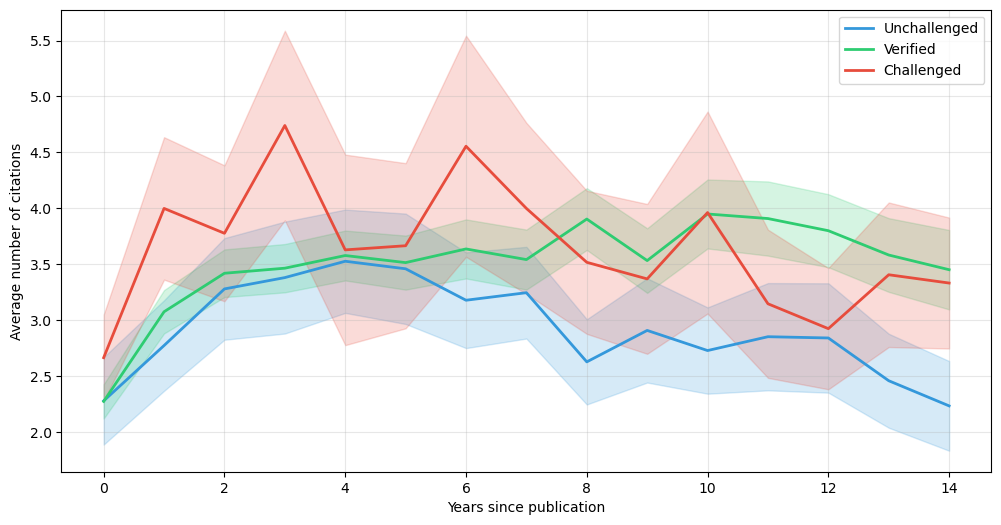

In [3]:


    
# Create simplified categories
category_mapping = {
    'Verified': 'Verified',
    'Verified by same authors': 'Verified',
    'Verified by reproducibility project': 'Verified',
    'Challenged': 'Challenged',
    'Challenged by reproducibility project': 'Challenged',
    'Challenged by same authors': 'Challenged',
    'Unchallenged': 'Unchallenged',
    'Unchallenged, logically consistent': 'Unchallenged',
    'Unchallenged, logically inconsistent': 'Unchallenged'
}

# Map categories and filter for main categories
merged_df['simplified_assessment'] = merged_df['assessment_type'].map(category_mapping)
merged_df = merged_df[merged_df['simplified_assessment'].notna()]


def calculate_citation_statistics(df):
    """
    Calculate citation statistics for each category
    """
    citation_cols = [col for col in df.columns if 'Citations' in col]
    stats = {}
    
    for category in df['simplified_assessment'].unique():
        category_data = df[df['simplified_assessment'] == category]
        
        # Calculate mean citations per year
        yearly_means = category_data[citation_cols].mean()
        
        # Calculate standard error
        yearly_se = category_data[citation_cols].sem()
        
        stats[category] = {
            'means': yearly_means,
            'se': yearly_se
        }
    
    return stats

def plot_citation_patterns(stats):
    """
    Create visualization of citation patterns
    """
    plt.figure(figsize=(12, 6))
    
    colors = {'Verified': '#2ecc71', 'Challenged': '#e74c3c', 'Unchallenged': '#3498db'}
    years = range(16)  # 0 to 10 years
    
    for category, data in stats.items():
        means = data['means']
        se = data['se']
        
        plt.plot(years, means, label=category, color=colors[category], linewidth=2)
        plt.fill_between(years, 
                        means - se, 
                        means + se, 
                        alpha=0.2, 
                        color=colors[category])
    
    plt.xlabel('Years since publication')
    plt.ylabel('Average number of citations')
    #plt.title('Citation Patterns by Assessment Type')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    return plt

def create_citation_heatmap(df):
    """
    Create a heatmap showing citation patterns
    """
    citation_cols = [col for col in df.columns if 'Citations' in col]
    pivot_data = df.pivot_table(
        values=citation_cols,
        index='simplified_assessment',
        aggfunc='mean'
    )
    
    plt.figure(figsize=(12, 4))
    sns.heatmap(pivot_data, 
                cmap='YlOrRd', 
                annot=True, 
                fmt='.1f', 
                cbar_kws={'label': 'Average Citations'})
    plt.title('Citation Heatmap by Assessment Type')
    plt.xlabel('Years since publication')
    plt.ylabel('Assessment Type')
    
    return plt


    
    # Calculate statistics
stats = calculate_citation_statistics(merged_df)

# Create visualizations
plot_citation_patterns(stats)
plt.savefig('figures/fig12_citation_patterns.png')

    
#create_citation_heatmap(merged_df)
#plt.savefig('figures/citation_heatmap.png')

    
# Calculate and print summary statistics
summary = pd.DataFrame({
    category: {
        'Total Citations': merged_df[merged_df['simplified_assessment'] == category][
            [col for col in merged_df.columns if 'Citations' in col]
        ].sum().sum(),
        'Average Citations per Year': merged_df[merged_df['simplified_assessment'] == category][
            [col for col in merged_df.columns if 'Citations' in col]
        ].mean().mean(),
        'Number of Claims': len(merged_df[merged_df['simplified_assessment'] == category])
    }
    for category in merged_df['simplified_assessment'].unique()
}).T

print("\nSummary Statistics:")
print(summary)







In [7]:
import pymc as pm
# Data: k1 out of n1 in group1, k2 out of n2 in group2
k1, n1 = 30, 150  # e.g., 30 challenged out of 150 high-impact journal claims
k2, n2 = 10, 100  # e.g., 10 out of 100 low-impact journal claims

with pm.Model():
    p1 = pm.Beta('p1', alpha=1, beta=1)
    p2 = pm.Beta('p2', alpha=1, beta=1)
    obs1 = pm.Binomial('obs1', n=n1, p=p1, observed=k1)
    obs2 = pm.Binomial('obs2', n=n2, p=p2, observed=k2)
    trace = pm.sample(2000, tune=1000, cores=2, compile=False)

# Extract posterior samples of difference
diff = trace['p1'] - trace['p2']
print(f"Posterior Pr(p1>p2) = {np.mean(diff>0):.2f}")
print(f"95% credible interval for difference = {np.percentile(diff,[2.5,97.5])}")


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: constant_folding
ERROR (pytensor.graph.rewriting.basic): node: Cast{float64}(1)
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/chadi/anaconda3/lib/python3.11/site-packages/pytensor/graph/rewriting/basic.py", line 1920, in process_node
    replacements = node_rewriter.transform(fgraph, node)
                   ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/chadi/anaconda3/lib/python3.11/site-packages/pytensor/graph/rewriting/basic.py", line 1081, in transform
    return self.fn(fgraph, node)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/Users/chadi/anaconda3/lib/python3.11/site-packages/pytensor/tensor/rewriting/basic.py", line 1121, in constant_folding
    thunk = node.op.make_thunk(node, storage_map, compute_map, no_recycling=[])
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/chad


You can find the C code in this temporary file: /var/folders/pj/15hxgl0j1wg2w_t5k7bvnq5c0000gn/T/pytensor_compilation_error_22ur7wyi

You can find the C code in this temporary file: /var/folders/pj/15hxgl0j1wg2w_t5k7bvnq5c0000gn/T/pytensor_compilation_error_dbq6ikhx

You can find the C code in this temporary file: /var/folders/pj/15hxgl0j1wg2w_t5k7bvnq5c0000gn/T/pytensor_compilation_error_jjsfq05i


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: constant_folding
ERROR (pytensor.graph.rewriting.basic): node: Cast{float64}(2)
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/chadi/anaconda3/lib/python3.11/site-packages/pytensor/graph/rewriting/basic.py", line 1920, in process_node
    replacements = node_rewriter.transform(fgraph, node)
                   ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/chadi/anaconda3/lib/python3.11/site-packages/pytensor/graph/rewriting/basic.py", line 1081, in transform
    return self.fn(fgraph, node)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/Users/chadi/anaconda3/lib/python3.11/site-packages/pytensor/tensor/rewriting/basic.py", line 1121, in constant_folding
    thunk = node.op.make_thunk(node, storage_map, compute_map, no_recycling=[])
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/chad


You can find the C code in this temporary file: /var/folders/pj/15hxgl0j1wg2w_t5k7bvnq5c0000gn/T/pytensor_compilation_error_x6oj_ztx

You can find the C code in this temporary file: /var/folders/pj/15hxgl0j1wg2w_t5k7bvnq5c0000gn/T/pytensor_compilation_error_zby09_y3

You can find the C code in this temporary file: /var/folders/pj/15hxgl0j1wg2w_t5k7bvnq5c0000gn/T/pytensor_compilation_error_zwr8d9um


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: constant_folding
ERROR (pytensor.graph.rewriting.basic): node: Cast{float64}(1)
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/chadi/anaconda3/lib/python3.11/site-packages/pytensor/graph/rewriting/basic.py", line 1920, in process_node
    replacements = node_rewriter.transform(fgraph, node)
                   ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/chadi/anaconda3/lib/python3.11/site-packages/pytensor/graph/rewriting/basic.py", line 1081, in transform
    return self.fn(fgraph, node)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/Users/chadi/anaconda3/lib/python3.11/site-packages/pytensor/tensor/rewriting/basic.py", line 1121, in constant_folding
    thunk = node.op.make_thunk(node, storage_map, compute_map, no_recycling=[])
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/chad


You can find the C code in this temporary file: /var/folders/pj/15hxgl0j1wg2w_t5k7bvnq5c0000gn/T/pytensor_compilation_error_9g7h18iv

You can find the C code in this temporary file: /var/folders/pj/15hxgl0j1wg2w_t5k7bvnq5c0000gn/T/pytensor_compilation_error_nmcwnipg


CompileError: Compilation failed (return status=1):
/Users/chadi/anaconda3/bin/clang++ -dynamiclib -g -Wno-c++11-narrowing -fno-exceptions -fno-unwind-tables -fno-asynchronous-unwind-tables -DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION -fPIC -undefined dynamic_lookup -I/Users/chadi/anaconda3/lib/python3.11/site-packages/numpy/core/include -I/Users/chadi/anaconda3/include/python3.11 -I/Users/chadi/anaconda3/lib/python3.11/site-packages/pytensor/link/c/c_code -L/Users/chadi/anaconda3/lib -fvisibility=hidden -o /Users/chadi/.pytensor/compiledir_macOS-15.4-arm64-arm-64bit-arm-3.11.0-64/lazylinker_ext/lazylinker_ext.so /Users/chadi/.pytensor/compiledir_macOS-15.4-arm64-arm-64bit-arm-3.11.0-64/lazylinker_ext/mod.cpp
In file included from /Users/chadi/.pytensor/compiledir_macOS-15.4-arm64-arm-64bit-arm-3.11.0-64/lazylinker_ext/mod.cpp:1:
In file included from /Users/chadi/anaconda3/lib/python3.11/site-packages/pytensor/link/c/c_code/pytensor_mod_helper.h:4:
/Users/chadi/anaconda3/include/python3.11/Python.h:23:12: fatal error: 'stdlib.h' file not found
#  include <stdlib.h>
           ^~~~~~~~~~
1 error generated.
